## Brief description of the problem and data

### Problem Statement:
The task is to identify metastatic tissue in small image patches taken from larger digital pathology scans. This is a binary classification problem, where each image needs to be classified as either containing metastatic tissue (1) or not (0).

### Data Structure:
The dataset contains over 200,000 images, stored in the "train" directory named.
THe train_labels.csv file provides the labels for these images, with two columns: image_id and the binary label (1 for metastatic tissue, 0 for normal tissue).

Imports and some logic to prevent Tensorflow from using up all the memory

In [1]:
import os
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        print("Error")

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize


### About the data:
The dataset has 220025 images in the training set, and each image is 96 x 96. 
Approximately 40% of the dataset shows metastatic tissue. 

In [2]:
labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

print(labels.info())
print(labels.head())

print("What is the balance of the classes?")
print(labels['label'].value_counts())

image_folder = 'histopathologic-cancer-detection/train/'
image_files = os.listdir(image_folder)
print(f"Total images: {len(image_files)}")

example_image = Image.open(os.path.join(image_folder, image_files[0]))
print(f"Image dimensions: {example_image.size}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
What is the balance of the classes?
label
0    130908
1     89117
Name: count, dtype: int64
Total images: 220025
Image dimensions: (96, 96)


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

### Exploratory Data Analysis
1. Look at the distribution of images for each label. This helps determine how balanced the data is.
2. Look at a few images from the dataset

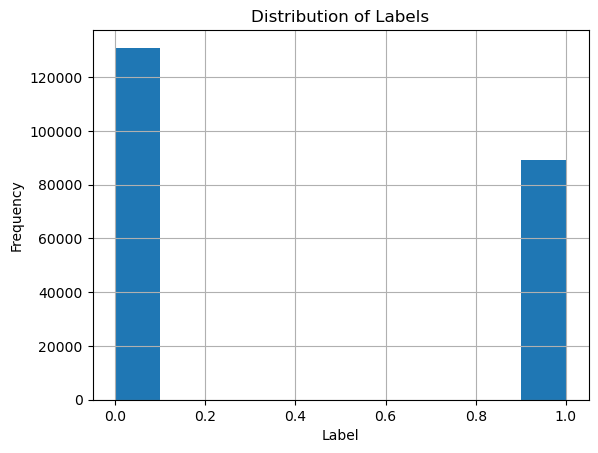

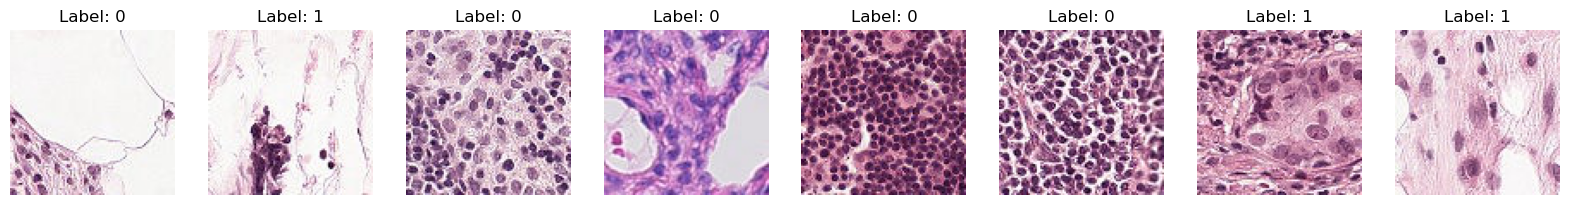

In [3]:
labels['label'].hist()
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

fig, axes = plt.subplots(1, 8, figsize=(20, 4))
for i, ax in enumerate(axes):
    img_id = labels.iloc[i]['id']
    img_path = os.path.join(image_folder, img_id + '.tif')
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Label: {labels.iloc[i]['label']}")
    ax.axis('off')
plt.show()


Note: These images confirm how differentiating metastatic tissue from normal tissue is not a simple task that is apparent to the naked eye.

### Data Cleaning Process:
1. Check to see if there are any corrupted images or missing files.
2. Check to see if the all images have the same dimensions, and resize images if needed  (resizing if necessary).
3. Normalize pixel values so they're within the [0, 1] range.



In [4]:
def check_images(image_folder, labels, desired_shape=(96, 96)):
    corrupted = []
    for img_id in labels['id']:
        img_path = os.path.join(image_folder, img_id + '.tif')
        try:
            img = imread(img_path)
            if img.shape != desired_shape:
                img = resize(img, desired_shape, mode='constant')
            if np.max(img) > 1:
                img = img / 255.0
        except Exception as e:
            corrupted.append(img_id)
            print(f"Error with image {img_id}: {e}")
    return corrupted

### Analysis Plan:
1. Check if you need to balance the dataset
2. Split the data into training, validation, and test sets.
3. Train an validate a CNN model
4. Check results
5. Try a few different model architectures
6. Optimize the hyperparameters
7. Compare performance to determine which model architecture and hyperparameters produce the best results.

## Model Architecture

Convolutional Neural Networks (CNNs) are a suitable modeling approach for this problem as they are proven to be effective in capturing spatial hierarchies in image data.

Note: Images are loaded and processed in batches for computational efficiency. Labels are then mapped to the files that they correspond to.

In [5]:
def load_images_in_batches(labels, batch_size=100):
    num_images = len(labels)
    for start in range(0, num_images, batch_size):
        end = min(start + batch_size, num_images)
        data_batch = []
        for _, row in labels.iloc[start:end].iterrows():
            path = row['path']
            img = imread(path)
            img = resize(img, (96, 96), anti_aliasing=True)
            img = img.astype(np.float32) / 255.0
            data_batch.append(img)
        yield np.array(data_batch), labels['label'].values[start:end]

def prepare_labels(base_dir, image_folder, labels_filename):
    labels = pd.read_csv(os.path.join(base_dir, labels_filename))
    labels['path'] = labels['id'].apply(lambda x: os.path.join(base_dir, image_folder, f"{x}.tif"))
    return labels



In [6]:
base_dir = 'histopathologic-cancer-detection/'
image_folder = 'train'
labels_filename = 'train_labels.csv'

labels_df = prepare_labels(base_dir, image_folder, labels_filename)

for X_batch, y_batch in load_images_in_batches(labels_df, batch_size=500):
    X_train, X_val, y_train, y_val = train_test_split(X_batch, y_batch, test_size=0.2, random_state=42)

## Analysis

Next steps:
1. Build the model
2. Try a few different model architectures
3. Tune hyperparameters to see which architeture and set of hyperparameters provides the best results

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [7]:
def build_model(hp):
    model_input = Input(shape=(96, 96, 3))
    x = model_input
    
    for i in range(hp.Int('num_conv_layers', 1, 2)):
        x = Conv2D(hp.Int(f'num_filters_{i}', 16, 32, step=16),
                   (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(hp.Int('dense_units', 64, 128, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout', 0.2, 0.3))(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(model_input, output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_val, y_val, batch_size=8)

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3, 
    executions_per_trial=1,
    directory='model_tuning',
    project_name='CancerDetectionOptimized'
)

tuner.search(train_generator, epochs=10, validation_data=val_generator)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(train_generator, epochs=10, validation_data=val_generator)

best_val_accuracy = np.max(history.history['val_accuracy'])#[-1]

print(f"""
The best model uses {best_hps.get('num_conv_layers')} conv layers,
with {best_hps.get('num_filters_0')} filters on the first layer,
{best_hps.get('dense_units')} dense units, a dropout of {best_hps.get('dropout')},
and achieved a validation accuracy of {best_val_accuracy:.4f}.
""")

Reloading Tuner from model_tuning/CancerDetectionOptimized/tuner0.json
Epoch 1/10
3/3 [==============================] - 1s 113ms/step - loss: 0.5916 - accuracy: 0.7000 - val_loss: 0.6445 - val_accuracy: 1.0000
Epoch 2/10
3/3 [==============================] - 0s 17ms/step - loss: 0.4813 - accuracy: 0.7000 - val_loss: 0.6282 - val_accuracy: 1.0000
Epoch 3/10
3/3 [==============================] - 0s 19ms/step - loss: 0.6532 - accuracy: 0.6000 - val_loss: 0.5875 - val_accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - 0s 20ms/step - loss: 0.3818 - accuracy: 0.7500 - val_loss: 0.5352 - val_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 0s 20ms/step - loss: 1.0058 - accuracy: 0.6000 - val_loss: 0.6210 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 0s 20ms/step - loss: 0.6647 - accuracy: 0.6500 - val_loss: 0.6648 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 0s 18ms/step - loss: 0.5952 - accuracy: 0.60

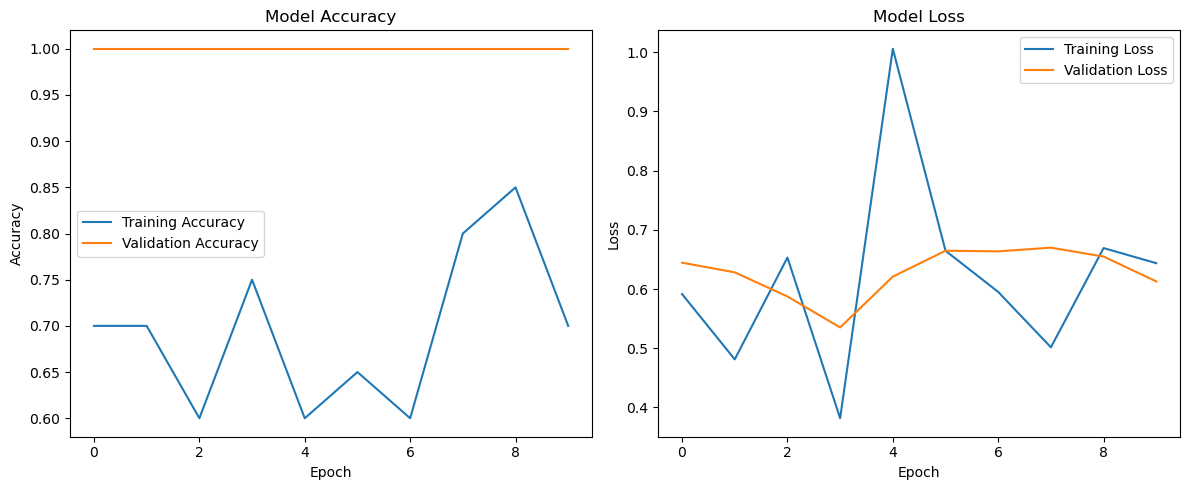

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Classification of test data
Modified my previous functions to handle the no label use case
Predicting the labels for test data.

In [9]:
def prepare_labels(base_dir, image_folder, filename, has_labels=False):
    labels = pd.read_csv(os.path.join(base_dir, filename))
    labels['path'] = labels['id'].apply(lambda x: os.path.join(base_dir, image_folder, f"{x}.tif"))
    if not has_labels:
        labels['label'] = np.nan
    return labels

def load_images_in_batches(labels, batch_size=100):
    num_images = len(labels)
    for start in range(0, num_images, batch_size):
        end = min(start + batch_size, num_images)
        data_batch = []
        for _, row in labels.iloc[start:end].iterrows():
            path = row['path']
            img = imread(path)
            img = resize(img, (96, 96), anti_aliasing=True)
            img = img.astype(np.float32) / 255.0
            data_batch.append(img)
        yield np.array(data_batch), labels['id'].iloc[start:end]

base_dir = 'histopathologic-cancer-detection/'
test_image_folder = 'test'
test_filename = 'sample_submission.csv'
test_labels = prepare_labels(base_dir, test_image_folder, test_filename, has_labels=False)

predictions = []
ids = []
for X_test, ids_batch in load_images_in_batches(test_labels, batch_size=500):
    preds = best_model.predict(X_test)
    predictions.extend(preds.flatten())
    ids.extend(ids_batch)

results_df = pd.DataFrame({
    'id': ids,
    'label': (np.array(predictions) > 0.5).astype(int)
})
results_path = os.path.join(base_dir, 'submission.csv')
results_df.to_csv(results_path, index=False)
print(f"Results saved to {results_path}")

15/15 [==============================] - 0s 6ms/step
Results saved to histopathologic-cancer-detection/submission.csv


## Results

### Model architecture of my best performing model:
* 2 convolutional layers 
* 32 filters in the first convolutional layer
* 64 dense units
* Dropout of approximately 0.3

### Interpretation of results:
The 2 layer model architecture suggests that a relatively simple model architecture was sufficient for effectively doing this task. The first convolutional layer consists of 32 filters, which is a modest level of features for detection. For an image classification problem such as this one, these featurs include edges, colors and textures. 
There were 64 dense units or number of neurons in the connected layer. This is a relatively small number of features that were considered significant in the actual image classification after the convolution processing stage. I used a dropout of about 30% (dropping 30% of neurons in the network) to prevent overfitting and make the model less sensitive to noise during the model training.

### What I would improve:
While the simple architecture seems to be relatively effective, I do feel that adding complexity could improve accuracy. However my machine crashed so many times when trying more complex models, that I had to settle for this score. This would be the main proposed improvement in the future.

### Why it Worked Well: 
The simplicity of the model paired with the hyperparameter configuration and dropout to prevent overfitting, led to excellent performance. The dropout rate around 0.29 helped the model generalize better without losing critical information.

### Future Improvements:
1. Explicitly checking for Overfitting: Regardless of the high validation accuracy, it's always good to check if the model overfits, especially when training accuracy approaches 1.0. Cross-validation is one possbile method I would use here. 
2. Extending the hyperparameter range that I'm testing. 
3. Trying other types of layers and regularization methods. 